In [1]:
import json
import pprint
from collections import Counter
from operator import itemgetter
import csv
from dotmap import DotMap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import keplergl

In [2]:
import pandas as pd
import numpy as np
import json
import pprint
from datetime import datetime
import keplergl
from dateutil import relativedelta      # https://thispointer.com/python-get-difference-between-two-dates-in-years/
import matplotlib.pyplot as plt
import geopandas as gpd
from pyvis import network as net
import networkx as nx
import scipy

In [3]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

In [4]:
# pulizzia delle stringhe

def clean_up_str(string):
    a = ''
    if string:
        a = string.replace('\xa0', '').replace('  ', ' ').strip()
    return a  



# calcolo dell'anno (medio)

def date(r_col):

    lista=[]
    for v in r_col['values']:
        if v.value.timePrimitive:
            lista.append(int(v.value.timePrimitive.label[:4]))
            
    if len(lista)>=1:
        return int(np.rint(np.mean(lista)))
    else:
        return np.nan




# sintesi time-spen (anno medio: begin, at some time, end)

def datatio(r_col_begin, r_col_someTime, r_col_end, element):

    begin, some_time, end = date(r_col_begin), date(r_col_someTime), date(r_col_end)
    element+= [begin, some_time, end]

    return(element)


-------------

# I. Processetti - Panoramica generale

**Obbiettivo**: Analizzare e visualizzare la distribuzione dei processetti nel tempo con la possibilità di individuare specifici archi cronologici di interesse e aggregati sulla base della ‘motivation type’ (MT)

In [5]:
file = 'geovistory_query_exports/nb_overwiev_processetti_20220510.json'

with open(file, encoding='utf-8') as json_file:
    data = json.load(json_file)

dmData = DotMap(data)
dm_r = dmData.rows


### Processetti list = psl

psl=[['volume', 'section', 'number_archival_units', 'pk_processetto', 'enquiry', 'motivation_type',
 'start_date','end_date', 'anno', 'id_union', 'number_union']]


for r in dm_r:
    element = []
    # volume
    element += ['-'.join([v.entity_label for v in r.col_0.entities]) if len(r.col_0.entities)>=1 else np.nan]   

    # sezione (unità archivistica)
    element += [clean_up_str(r.col_1.entities[0].entity_label)]

    # numero di section per enquiry 
    element += [len(r.col_1.entities)]

    # enquiry 
    element += [r.col_2.entity.pk_entity, clean_up_str(r.col_2.entity.entity_label)]
   
    # motivation type
    element += [clean_up_str('; '.join([v.entity_label for v in r.col_3.entities])) if len(r.col_3.entities)>=1 else np.nan]

    # arco e anno processetto
    valor = []
    if len(r.col_4['values']) == 0:
        element += [np.nan, np.nan, np.nan]
    else:
        for v in  r.col_4['values']:
            valor.append(int(v.value.timePrimitive.label[:4]))
        element += [r.col_4['values'][0]['value'].timePrimitive.label[:10], r.col_4[
            'values'][len(r.col_4['values'])-1]['value'].timePrimitive.label[:10], round(np.mean(valor))]

    # union
    if len(r.col_5.entities)==1:
        element += [r.col_5.entities[0].pk_entity, len(r.col_5.entities)]
    elif len(r.col_5.entities)>1:
        element += ['-'.join([str(v.pk_entity) for v in r.col_5.entities]) if len(r.col_5.entities)>=1 else np.nan, len(r.col_5.entities)]  
    else:
        element += [np.nan, 0]
        
    psl.append(element)
    

df_proc = pd.DataFrame(psl[1:], columns=psl[0])  
df_proc.head()

    

,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union
0,EM 04,Processetto di Giovanni di Michele (da Cessalto),1,1006519,Giovanni di Michele (da Cessalto),Stato libero di “foresto”,1597-05-23,1597-05-23,1597.0,NaN,0
1,EM 05,Processetto di Francesco di Vincenzo Moscato (...,1,1006729,"Francesco di Vincenzo Moscato (da Fabriano, te...",Stato libero di “foresto”,1598-12-27,1598-12-27,1598.0,NaN,0
2,EM 04,Processetto di Pietro di Gennaro Costinovi (da...,1,1006883,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",Stato libero di “foresto”,1597-05-26,1597-05-26,1597.0,NaN,0
3,EM 05,Processetto di Orsola di Angelo Collotis (da V...,1,1007147,Orsola di Angelo Collotis (da Visinale),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0
4,EM 05,Processetto di Ortensia di Leonardo Verona (da...,1,1007355,Ortensia di Leonardo Verona (da Venzone),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0


In [6]:
df_proc.motivation_type.unique()

array(['Stato libero di “foresto”', 'Vedovanza',
       'Stato libero di persona lungamente assente da Venezia; Stato libero di “foresto”',
       'Processetto atipico',
       'Stato libero di persona lungamente assente da Venezia',
       'Stato libero di veneziano', 'Vedovanza; Processetto atipico',
       'Vedovanza; Stato libero di “foresto”',
       'Stato libero di “foresto” ; Processetto atipico', nan,
       'Stato libero di persona lungamente assente da Venezia; Processetto atipico',
       'Stato libero di persona lungamente assente da Venezia; Stato libero di “foresto” ; Processetto atipico',
       'Stato libero di persona lungamente assente da Venezia; Vedovanza; Processetto atipico'],
      dtype=object)

In [7]:
# Integrazione del frame con colonne che permettano quantificazioni differenziate 


motivation_t =[]
lista_mt = []
aggregazione_mt = []
proc_type = []
for i, r in df_proc.iterrows():
    if isinstance(r.motivation_type, str):
        lista = r.motivation_type.split('; ')
        lista.sort()
        motivation = '; '.join(lista)
        lista_mt.append(lista)
        motivation_t.append(motivation)
        if ';' in r.motivation_type:
            aggregazione_mt.append('motivazioni plurime')
        else:
            aggregazione_mt.append(r.motivation_type)

        
        if 'atipico' in r.motivation_type:
            proc_typest = 'atipico'
        elif 'Vedovanza' in r.motivation_type:
            proc_typest = 'vedovanza'
        elif 'assente' in r.motivation_type:
            proc_typest = 'a lungo assente'
        elif 'libero' in r.motivation_type:
            proc_typest = 'stato libero'
        
        proc_type.append(proc_typest)
            

       
    else:
        lista_mt.append(np.nan)
        motivation_t.append(np.nan)
        aggregazione_mt.append(np.nan) 
        proc_type.append('manca')

df_proc['lista_mt'], df_proc['motivation_type'], df_proc['aggregazione_mt'], df_proc['mt_priorita'] = lista_mt, motivation_t, aggregazione_mt, proc_type
df_proc.head(4)


,volume,section,number_archival_units,pk_processetto,enquiry,motivation_type,start_date,end_date,anno,id_union,number_union,lista_mt,aggregazione_mt,mt_priorita
0,EM 04,Processetto di Giovanni di Michele (da Cessalto),1,1006519,Giovanni di Michele (da Cessalto),Stato libero di “foresto”,1597-05-23,1597-05-23,1597.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero
1,EM 05,Processetto di Francesco di Vincenzo Moscato (...,1,1006729,"Francesco di Vincenzo Moscato (da Fabriano, te...",Stato libero di “foresto”,1598-12-27,1598-12-27,1598.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero
2,EM 04,Processetto di Pietro di Gennaro Costinovi (da...,1,1006883,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",Stato libero di “foresto”,1597-05-26,1597-05-26,1597.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero
3,EM 05,Processetto di Orsola di Angelo Collotis (da V...,1,1007147,Orsola di Angelo Collotis (da Visinale),Stato libero di “foresto”,1598-12-29,1598-12-29,1598.0,NaN,0,[Stato libero di “foresto”],Stato libero di “foresto”,stato libero


<AxesSubplot:xlabel='volume'>

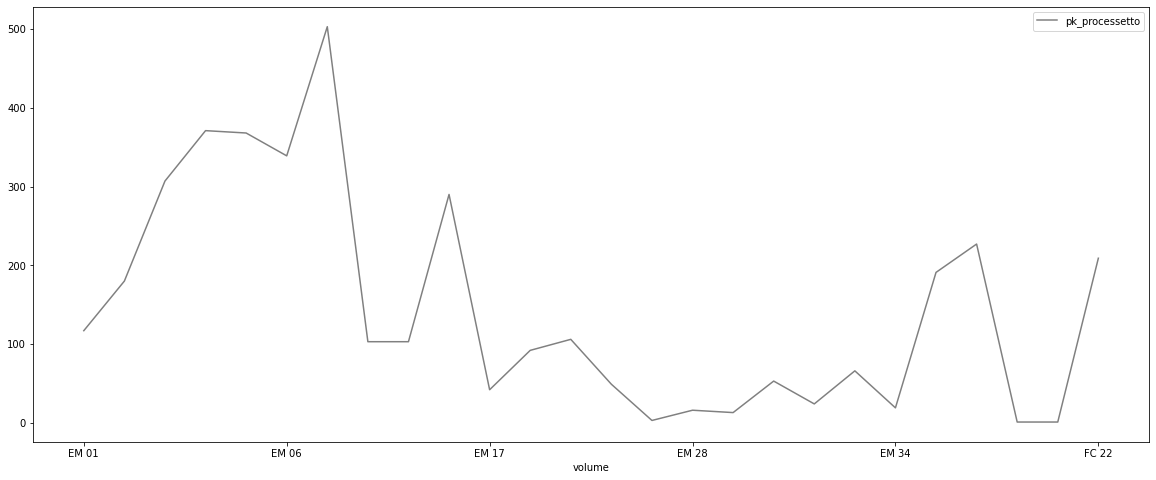

In [8]:
df_proc[df_proc.volume.str.len()<6].groupby('volume').agg({'pk_processetto': 'count'}).sort_values(by=['volume'], ascending=True).plot(figsize=(20,8), color='grey')

In [9]:
prova = df_proc[df_proc.volume.str.len()<6].groupby('volume').agg({'pk_processetto': 'count'}).sort_values(by=['volume'], ascending=True).reset_index()

In [10]:
data = go.Heatmap(x = list(prova.volume), z= list(prova.pk_processetto), y = list(prova.pk_processetto))
data = [data]
f = go.FigureWidget(data)
f

FigureWidget({
    'data': [{'type': 'heatmap',
              'uid': '827fa507-87e1-4310-ab6e-0b30b252c294',
 …

In [11]:
fig = px.line(x = list(prova.volume), y = list(prova.pk_processetto))
fig.show()

In [12]:
fig = dict({'data':[{'type':'bar', 'x': list(prova.volume), 'y' : list(prova.pk_processetto)}], 'layout':{'title':'processetti per volume'}})
pio.show(fig)

In [13]:
data = df_proc

In [14]:
df = data.sort_values(by='volume').query("anno>1590 & anno<1650")
px.scatter(df, x=list(df.anno), y='volume', size = df.merge(df.groupby('volume').agg({'section':'count'}).reset_index(), on='volume', how='left').section_y, color='volume', hover_name='section', marginal_x="histogram", template='none', labels={'volume':'', 'anno':'anno'}, height=1000)



In [15]:
# un record per menzione

proc_list= [['volume', 'section', 'number_archival_units', 'pk_processetto',
       'enquiry', 'motivation_type', 'start_date', 'end_date', 'anno',
       'id_union', 'number_union', 'lista_mt', 'aggregazione_mt', 'mt_priorita', 'mt_singola', 'conto_mt']]
       
for i,r in df_proc.iterrows():
    if isinstance(r.lista_mt, list):
        for el in r.lista_mt:
            element = [v for v in r] + [str(el).strip()] + [len(r.lista_mt)]
            proc_list.append(element)
    else:
        element = [v for v in r] + [np.nan] + [0]
        proc_list.append(element)

dfn_proc = pd.DataFrame(proc_list[1:], columns=proc_list[0])


        

>   è possibile ridurre il dataset a: 'Pk_processetto', 'anno', 'mt_singola'

In [16]:
# Conteggio delle MT 
df_proc.groupby('motivation_type').agg({'pk_processetto':'count'}).sort_values(by='pk_processetto', ascending=False)

,pk_processetto
motivation_type,
Stato libero di “foresto”,3009
Vedovanza,584
Stato libero di persona lungamente assente da Venezia,61
Processetto atipico,30
Stato libero di persona lungamente assente da Venezia; Stato libero di “foresto”,28
Stato libero di veneziano,24
Processetto atipico; Stato libero di “foresto”,21
Processetto atipico; Vedovanza,15
Stato libero di “foresto”; Vedovanza,15


In [17]:
for e in df_proc[df_proc['motivation_type'] =='Processetto atipico; Stato libero di persona lungamente assente da Venezia']['pk_processetto']:
    print(e)

1509842
1772738
778511


<AxesSubplot:xlabel='anno'>

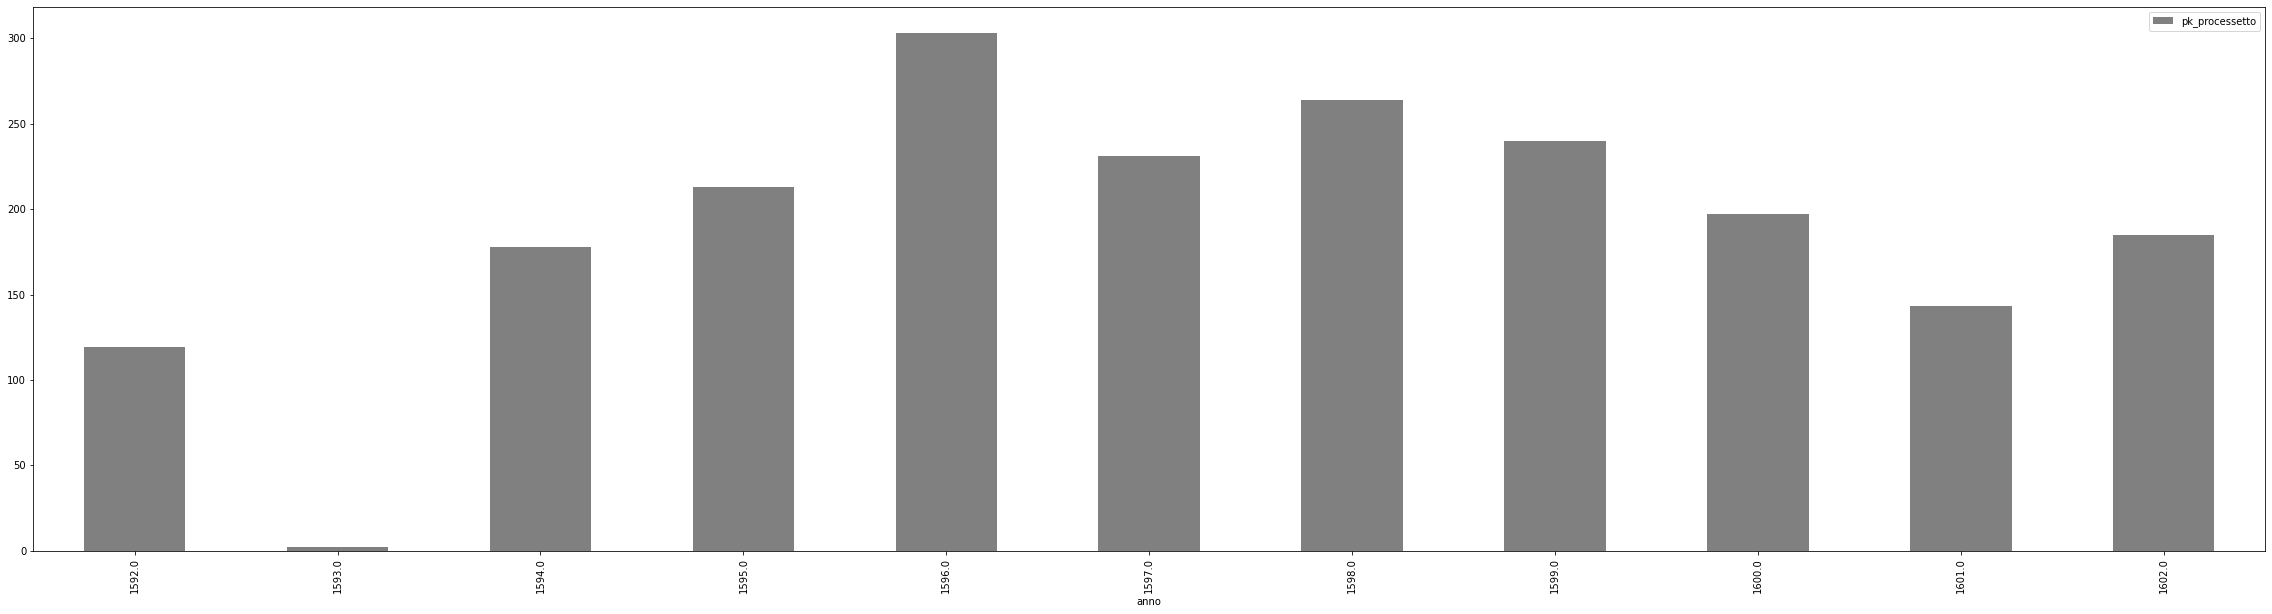

In [18]:

df_proc[(df_proc['anno']>1591 )& (df_proc['anno']<1603) ].groupby('anno').agg({'pk_processetto':'count'}).plot.bar(figsize=(40,10), color='gray')

In [19]:
# Conteggio di MT con priorità
df_proc.groupby('mt_priorita').agg({'pk_processetto':'count'}).sort_values(by='pk_processetto', ascending=False)

,pk_processetto
mt_priorita,
stato libero,3033
vedovanza,599
a lungo assente,89
atipico,71
manca,5


In [20]:
# Conteggio con aggregazione di MT multiple
df_proc.groupby('aggregazione_mt').agg({'pk_processetto':'count'}).sort_values(by='pk_processetto', ascending=False)

,pk_processetto
aggregazione_mt,
Stato libero di “foresto”,3009
Vedovanza,584
motivazioni plurime,84
Stato libero di persona lungamente assente da Venezia,61
Processetto atipico,30
Stato libero di veneziano,24


In [21]:
dfn_proc.mt_singola.unique()

array(['Stato libero di “foresto”', 'Vedovanza',
       'Stato libero di persona lungamente assente da Venezia',
       'Processetto atipico', 'Stato libero di veneziano', nan],
      dtype=object)

In [49]:
# Conteggio menzione MT  
dfn_proc.groupby('mt_singola').agg({'pk_processetto':'count'}).sort_values(by='pk_processetto', ascending=False)

,pk_processetto
mt_singola,
Stato libero di “foresto”,3074
Vedovanza,615
Stato libero di persona lungamente assente da Venezia,94
Processetto atipico,71
Stato libero di veneziano,24


<AxesSubplot:ylabel='mt_singola'>

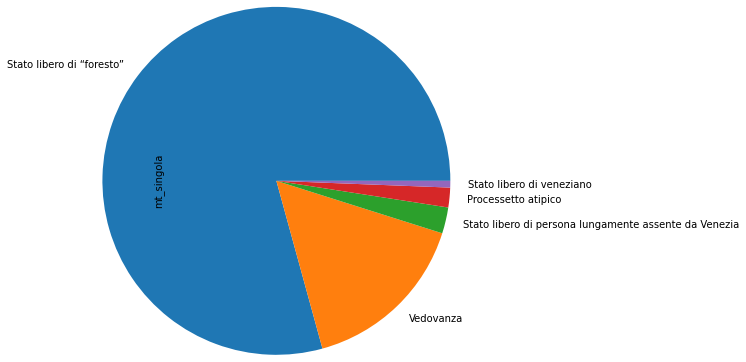

In [23]:
dfn_proc.mt_singola.value_counts().plot.pie(radius=2)

In [24]:
time_line = pd.RangeIndex(1585, 1694).to_frame().rename(columns={0:'time_line'})

<AxesSubplot:xlabel='time_line'>

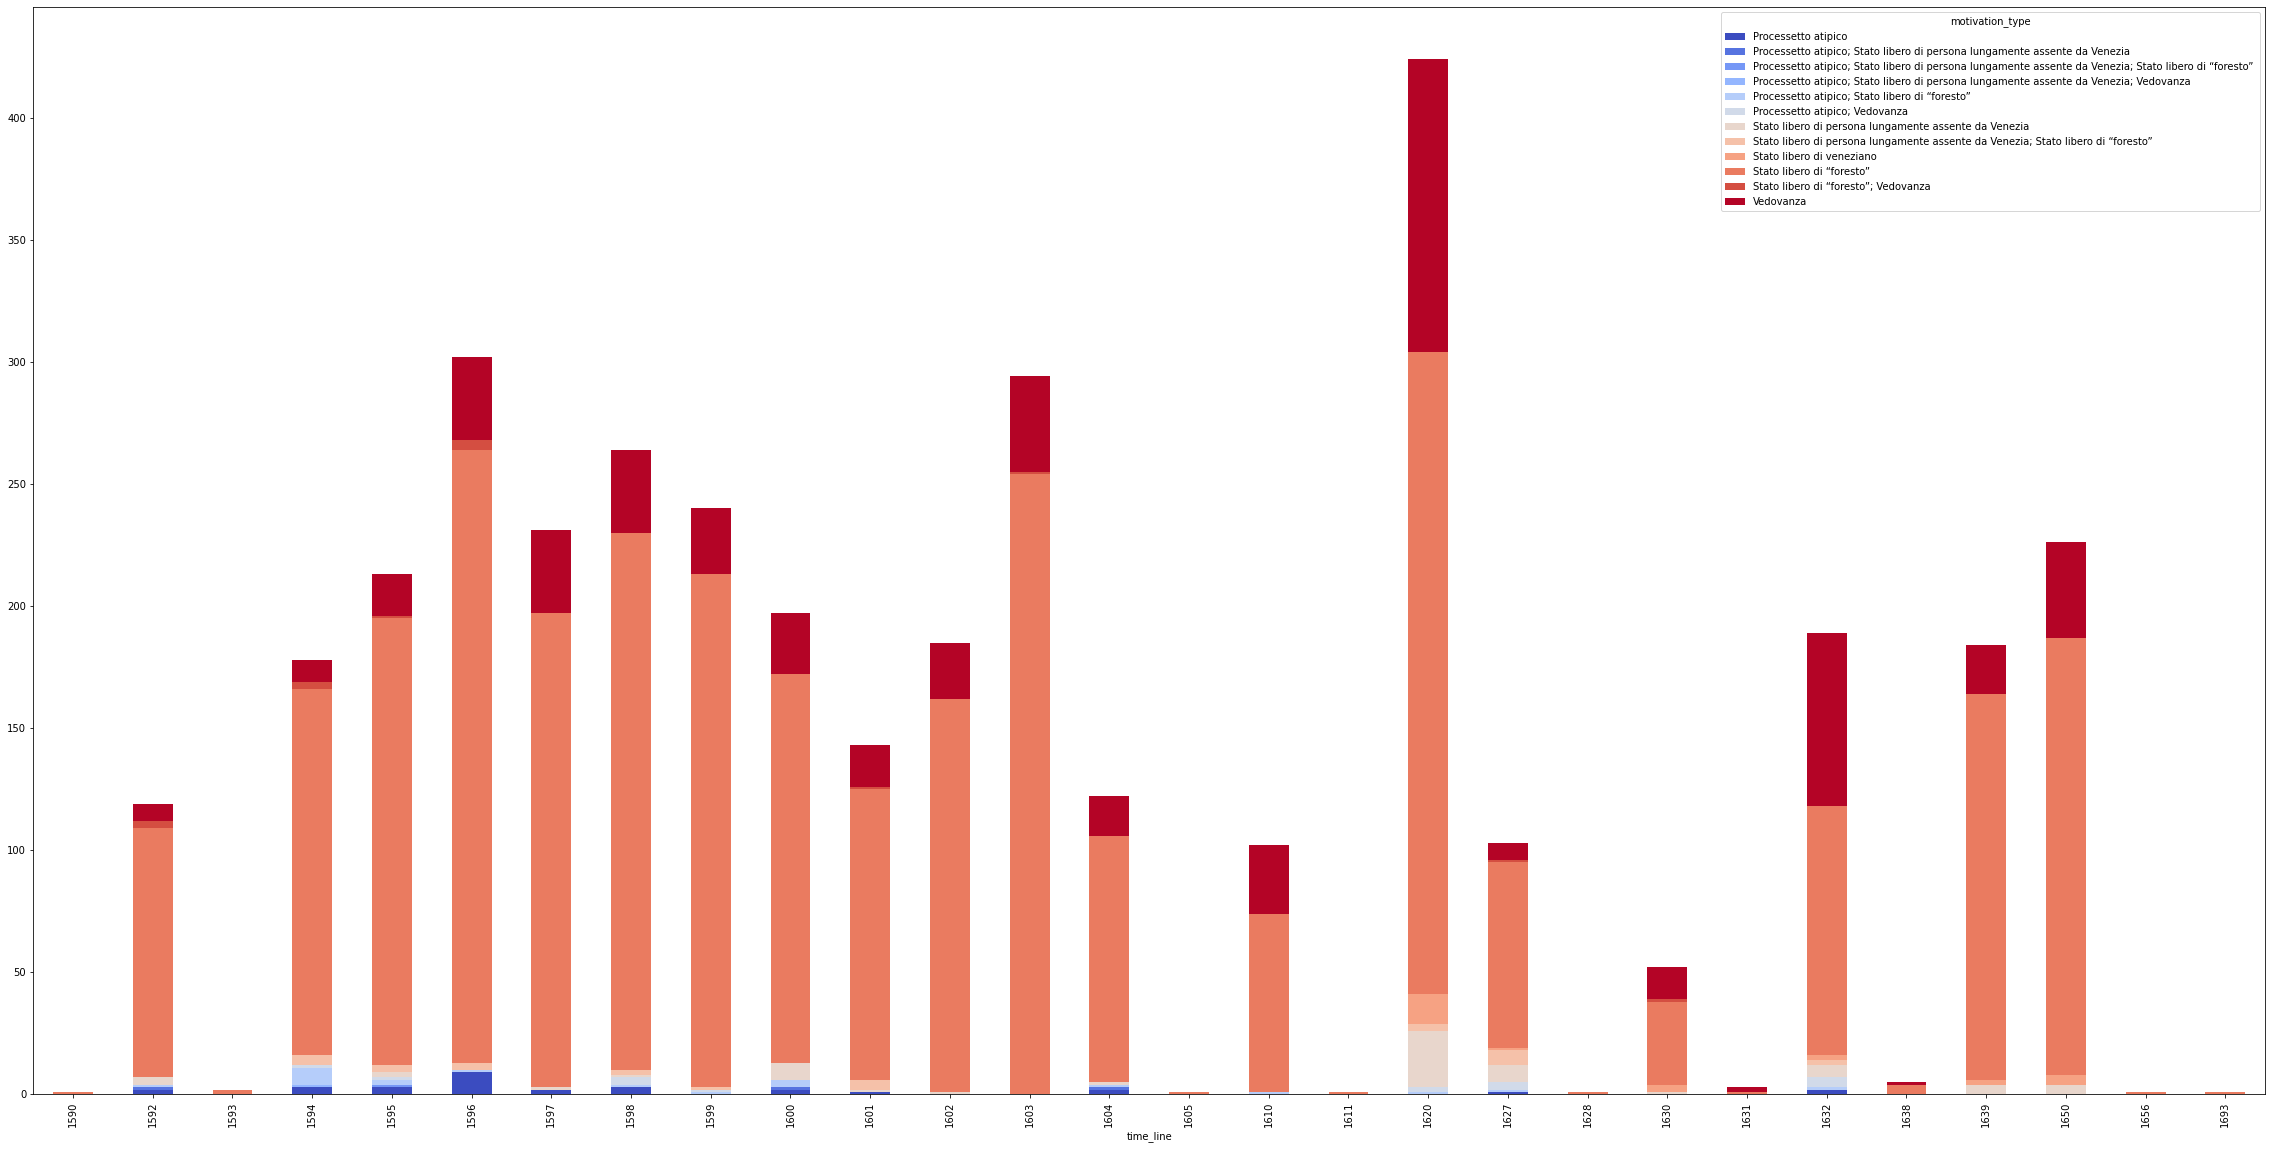

In [25]:
time_line.merge(df_proc, left_on='time_line', right_on='anno', how='left').pivot_table(values='pk_processetto', index='time_line', columns='motivation_type', aggfunc='count', fill_value=0).plot.bar(stacked="true", figsize=(40,20), colormap='coolwarm')

#### Integrazione con consistenza dei registri
<b> Obbiettivo:</b> Distribuzione dei processetti nel tempo, senza distinzione di MT <br> 
Il file di riferimento è: 
>   https://docs.google.com/spreadsheets/d/1OLm7DCt5-ZmMJmgqBDgMzWEr1gP2JjAZUjE1JalsBy8/edit#gid=0

In [26]:
sheet_id = '1OLm7DCt5-ZmMJmgqBDgMzWEr1gP2JjAZUjE1JalsBy8'
sheet_name= 'Conteggio'
url= f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

procSerie_count = pd.read_csv(url)
procSerie_count.head()

,registro(prov),estremi(prov),anno,gennaio,febbraio,marzo,aprile,maggio,giugno,luglio,...,settembre,ottobre,novembre,dicembre,serie,registro,cc.,data primo processetto,data ultimo processetto,tot. registro per anno
0,26,01/09/1629 - 06/05/31,1630,61.0,53.0,29.0,55.0,38.0,55.0,43.0,...,31.0,56.0,26.0,21.0,EM,26,100r-nn,01/09/1629,06/05/31,505
1,26,01/09/1629 - 06/05/31,1631,34.0,54.0,28.0,42.0,14.0,NaN,NaN,...,NaN,NaN,NaN,NaN,EM,26,NaN,01/09/1629,06/05/31,172
2,27,07/05/1631 - 22/11/1631,1631,NaN,NaN,NaN,NaN,38.0,65.0,35.0,...,68.0,40.0,37.0,NaN,EM,27,1r-107v,07/05/1631,22/11/1631,340
3,28,17/01/1632 - 06/02/1632,1632,36.0,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,EM,28,nn,17/01/1632,06/02/1632,45
4,29,01/01/1632 - 07/03/1632,1632,18.0,16.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,EM,29,nn,01/01/1632,07/03/1632,37


--------------------------------

# II. Profilo dei richiedenti e dei testimoni

**Obiettivo**: Analizzare e visualizzare l'età dei richiedenti e dei testimoni, incrociando il dato con: genere, origine, occupazione (per raggruppamento principale), motivation type

## Richiedenti:

Età dei richiedenti al momento del processetto

In [27]:
file = 'geovistory_query_exports/nb_richiedenti_20220510.json'

with open(file, encoding='utf-8') as json_file:
    data_ric = json.load(json_file)

dmr = DotMap(data_ric)
dmr_r = dmr.rows 

# Richiedenti list = rl

rl = [['pk_processetto',  'pk_person', 'person', 'qualità', 'genere', 'origini', 'id_gp', 'anno_nascita', 'professioni' ]]


for r in dmr_r:
    for el in r.col_0.entities:
        element = []
        element += [el.pk_entity]

        # pk_person, person, qualità, genere
        element += [r.col_1.entity.pk_entity, clean_up_str(r.col_1.entity.entity_label), 'richiedente', (
            r.col_2.entities[0].entity_label if len(r.col_2.entities)>0 else np.nan)]
        
        # origini
        element += [clean_up_str('; '.join(e.entity_label for e in r.col_3.entities)) if len(r.col_3.entities)>=1 else np.nan]
        # Integrazione di prova (assume come indicazione di origine solo l'ID della prima voce incontrata)
        element += [str(r.col_3.entities[0].pk_entity) if len(r.col_3.entities)>0 else np.nan]

        # Anno di nascita 
        element += [date(r.col_4)]
        
        # professioni
        element += ['; '.join(e.entity_label for e in r.col_5.entities) if len(r.col_5.entities)>=1 else np.nan]
        
        rl.append(element)


df_ric = pd.DataFrame(rl[1:], columns=rl[0])
df_ric = df_ric.merge(df_proc[['pk_processetto', 'motivation_type', 'mt_priorita',  'anno']], on='pk_processetto', how='left')
df_ric['età'] = df_ric['anno'] - df_ric['anno_nascita']
df_ric = df_ric[['pk_processetto', 'pk_person', 'person', 'qualità', 'età', 'anno_nascita', 'genere', 'origini', 'id_gp', 'professioni', 'motivation_type', 'mt_priorita']]; df_ric.head()



,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,id_gp,professioni,motivation_type,mt_priorita
0,1006519,1006422,Giovanni di Michele (da Cessalto),richiedente,21.0,1576.0,Maschile,Cessalto,999802,NaN,Stato libero di “foresto”,stato libero
1,1006883,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",richiedente,21.0,1576.0,Maschile,Bergamo,999686,cogo; tesser da panni,Stato libero di “foresto”,stato libero
2,1007147,1006856,Orsola di Angelo Collotis (da Visinale),richiedente,26.0,1572.0,Femminile,Visinale,1007155,masser,Stato libero di “foresto”,stato libero
3,1007355,1007216,Ortensia di Leonardo Verona (da Venzone),richiedente,25.0,1573.0,Femminile,Venzone,761022,masser,Stato libero di “foresto”,stato libero
4,1007563,1007388,"Vincenzo di Battista Betocchi (da Gandino, cas...",richiedente,26.0,1572.0,Maschile,Gandino,1007571,casariol,Stato libero di “foresto”,stato libero


### Età - Genere (media e mediana)

In [28]:
df_ric.groupby('genere').agg({'età':['mean', 'median', 'max', 'min']})

età                     
                mean median    max    min
genere                                   
Femminile  25.553279   25.0   60.0 -515.0
Maschile   26.770240   25.0  117.0    8.0

genere
Femminile    AxesSubplot(0.125,0.125;0.775x0.755)
Maschile     AxesSubplot(0.125,0.125;0.775x0.755)
Name: età, dtype: object

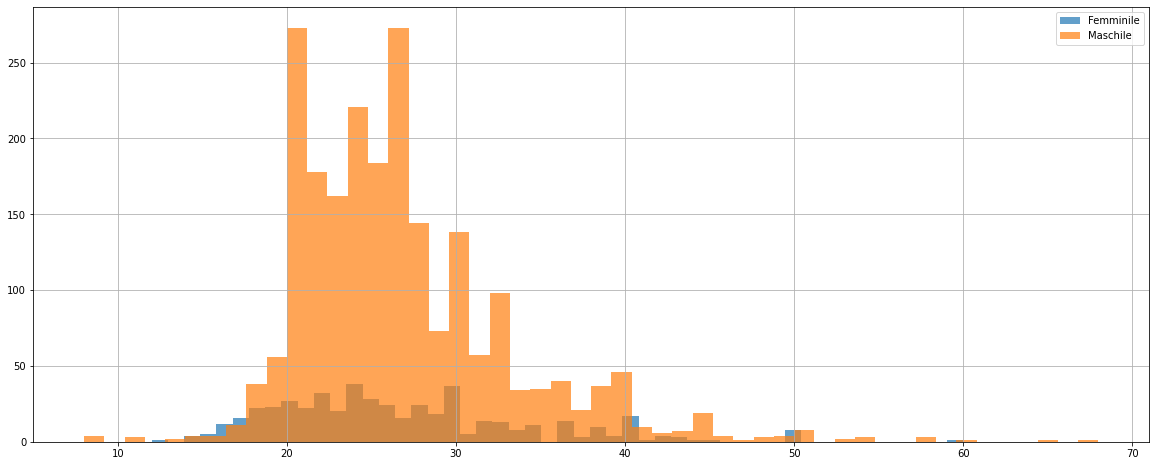

In [29]:
df_ric[(df_ric['età']>7)&(df_ric['età']<70)].groupby('genere').età.hist(bins=50, alpha=0.7, legend=True, figsize=(20,8))

### Età - Motivation Type

In [30]:
eta_tipo = df_ric[(df_ric['età']>7)&(df_ric['età']<70)][['età', 'mt_priorita']].pivot_table(index='età', columns='mt_priorita', aggfunc=len).fillna(0)

<AxesSubplot:xlabel='età'>

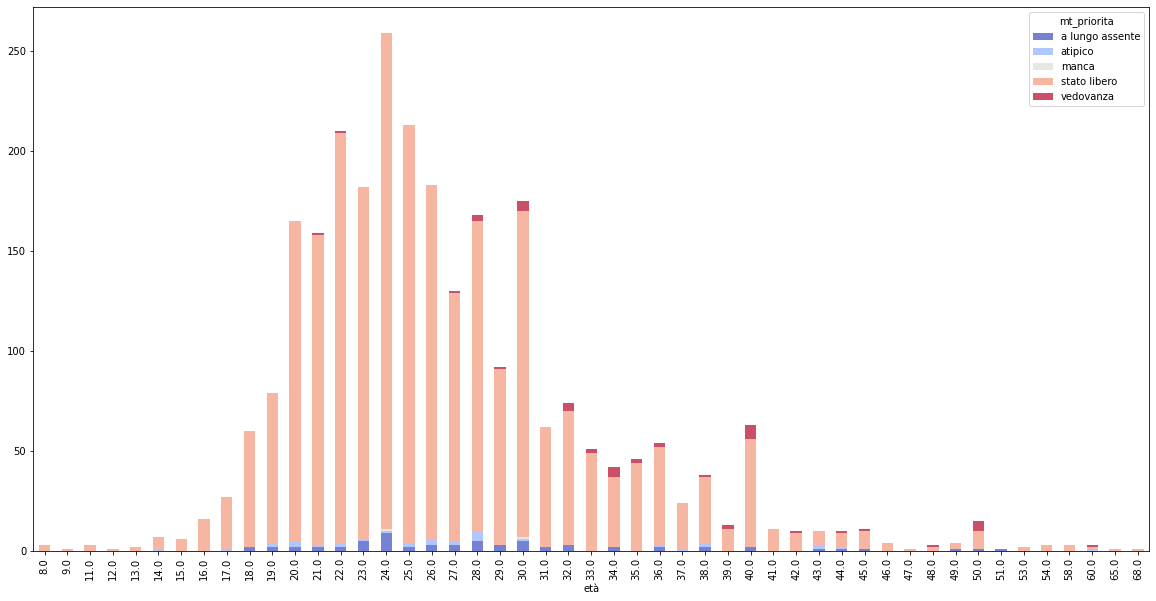

In [31]:
eta_tipo.plot.bar(stacked = True, figsize=(20,10), colormap='coolwarm', alpha=0.7)

In [32]:
temp = range(0,150,5)
l_list = []
for e in temp:
        l_list.append((e+1,e+5))

lustro = []
for e in df_ric['età'].fillna(0):
    if e in range(1,71):
        for rg in l_list:
            if e in range(rg[0], rg[1]+1):
                lustro.append('-'.join(str(r) for r in rg))
    else:
        lustro.append(np.nan)
    
df_ric['lustro'] = lustro


### Età - Motivation Type (aggregazione per lustro)

<AxesSubplot:xlabel='lustro'>

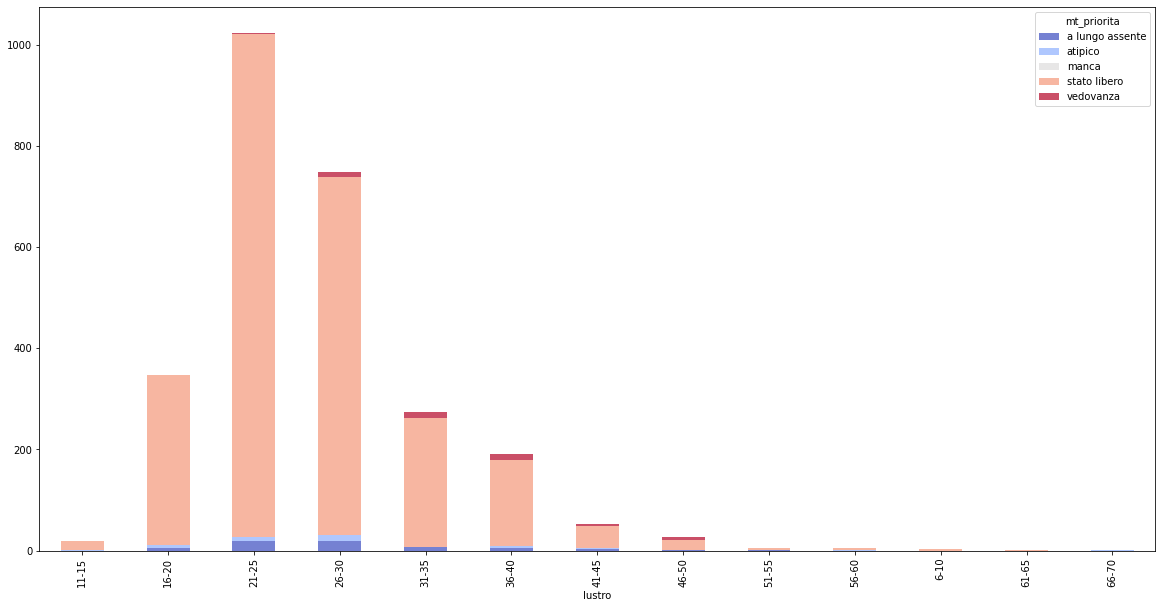

In [33]:
df_ric[(df_ric['lustro'].notnull())][['lustro', 'mt_priorita']].pivot_table(index='lustro', columns='mt_priorita', aggfunc=len).fillna(0).plot.bar(stacked = True, figsize=(20,10), colormap='coolwarm', alpha=0.7)

### Età - Genere (aggregazione per lusto)

<AxesSubplot:xlabel='lustro'>

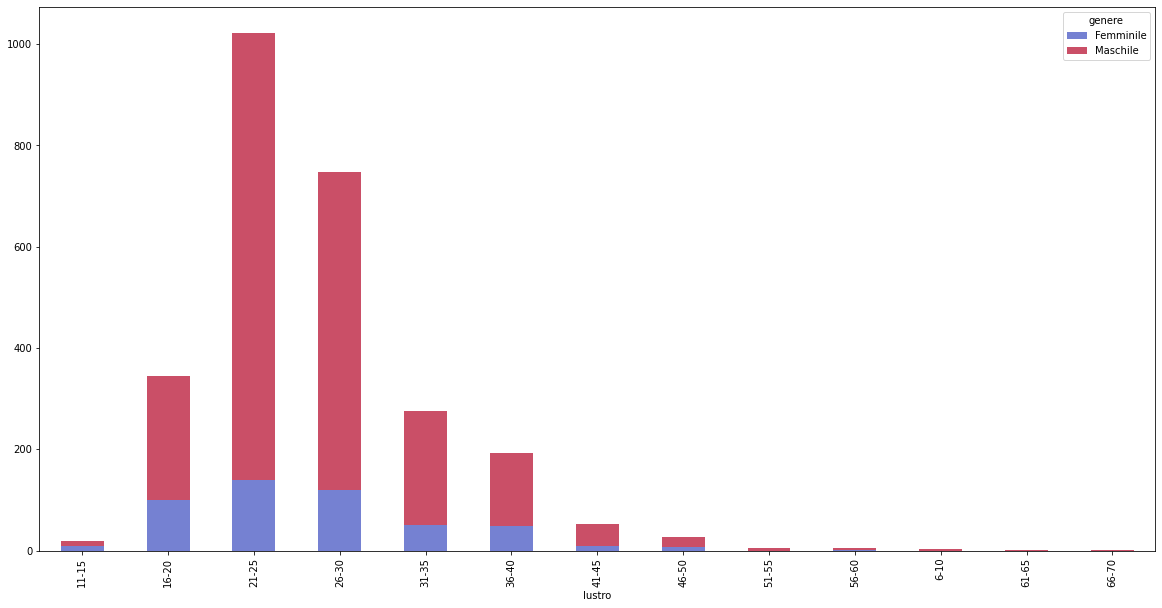

In [34]:
df_ric[(df_ric['lustro'].notnull())][['lustro', 'genere']].pivot_table(index='lustro', columns='genere', aggfunc=len).fillna(0).plot.bar(stacked = True, figsize=(20,10), colormap='coolwarm', alpha=0.7)

### Età - Genere - Motivation Type (media e mediana)

In [35]:
df_ric[['pk_processetto', 'pk_person', 'person',  'età',
        'genere']].merge(df_proc[['pk_processetto',
       'mt_priorita']], how='right', on='pk_processetto').groupby(['genere', 'mt_priorita']).agg(
        {'età':['mean', 'median'], 'pk_processetto':'count'}).sort_values(['genere', ('età', 'mean')])

# Si è scelto di ricorrere alle MT definite con attribuzione di priorità 
## Rimane possibile cambiare approccio, modificando la selezione della colonna in df_proc

età        pk_processetto
                                mean median          count
genere    mt_priorita                                     
Femminile a lungo assente  21.000000   21.0              3
          stato libero     25.042411   25.0            490
          atipico          26.642857   28.0             26
          vedovanza        34.833333   33.5            343
Maschile  stato libero     26.540143   25.0           2299
          manca            27.000000   27.0              2
          a lungo assente  29.209677   28.0             77
          atipico          31.450000   26.0             38
          vedovanza        37.636364   38.5            134

In [36]:
df_ric[['pk_processetto', 'pk_person', 'person',  'età',
        'genere']].merge(df_proc[['pk_processetto',
       'mt_priorita', 'anno']], how='right', on='pk_processetto').groupby(['genere','anno', 'mt_priorita']).agg(
        {'età':['mean', 'median'], 'pk_processetto':'count'})

età        pk_processetto
                                        mean median          count
genere    anno   mt_priorita                                      
Femminile 1061.0 stato libero    -515.000000 -515.0              1
          1592.0 a lungo assente   18.000000   18.0              1
                 atipico           20.000000   20.0              1
                 stato libero      26.562500   25.0             18
                 vedovanza               NaN    NaN              6
...                                      ...    ...            ...
Maschile  1650.0 a lungo assente   30.000000   30.0              3
                 manca             30.000000   30.0              1
                 stato libero      28.938931   27.0            140
                 vedovanza         40.000000   40.0              6
          1693.0 stato libero     117.000000  117.0              1

[124 rows x 3 columns]

### Età - Origine

In [37]:
# df Geographical Place

file = 'geovistory_query_exports/nb_geographicalPlace.json'

with open(file, encoding='utf-8') as json_file:
    data_gp = json.load(json_file)

dgp = DotMap(data_gp)

dgp_r = dgp.rows 


gpl = [['id_gp', 'gp_name', 'gp_type','len_person', 'lat', 'lon']]

for e in dgp_r:
    element = []
    element += [str(e.col_0.entity.pk_entity), e.col_0.entity.entity_label]
    element += [e.col_2.entities[0].entity_label if len(e.col_2.entities)>=1 else np.nan]
    element+= [len(e.col_3.entities)]
    if len(e.col_4['values'])>0:
        element += [e.col_4['values'][0].value.geometry.geoJSON.coordinates[1]]
        element += [e.col_4['values'][0].value.geometry.geoJSON.coordinates[0]]
    else:
        element += [np.nan, np.nan]
    gpl.append(element)

df_pl = pd.DataFrame(gpl[1:], columns=gpl[0])



In [38]:
df_ric = df_ric.merge(df_proc[['pk_processetto', 'anno']], on='pk_processetto', how='left')

In [39]:
df_pl

,id_gp,gp_name,gp_type,len_person,lat,lon
0,1006484,Fabriano,Città,5,43.338561,12.908519
1,1006843,Castel Cerreto,Luogo abitato,6,45.550556,9.576944
2,1007155,Visinale,Luogo abitato,2,45.896170,12.613650
3,1007463,S. Giovanni Elemosinario,Parrocchia,0,45.438769,12.333914
4,1007506,Sommacampagna,Città,1,45.400000,10.850000
...,...,...,...,...,...,...
1520,998962,Dosso,Luogo abitato,1,45.750000,10.283333
1521,999026,Lavino,Luogo abitato,3,45.750000,10.350000
1522,999241,Magno,Luogo abitato,1,45.707500,10.196667
1523,999686,Bergamo,Città,156,45.695000,9.670000


In [40]:
df_ric = df_ric.merge(df_pl, on='id_gp', how='left')
df_ric

,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,id_gp,professioni,motivation_type,mt_priorita,lustro,anno,gp_name,gp_type,len_person,lat,lon
0,1006519,1006422,Giovanni di Michele (da Cessalto),richiedente,21.0,1576.0,Maschile,Cessalto,999802,NaN,Stato libero di “foresto”,stato libero,21-25,1597.0,Cessalto,Città,7.0,45.716667,12.616667
1,1006883,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",richiedente,21.0,1576.0,Maschile,Bergamo,999686,cogo; tesser da panni,Stato libero di “foresto”,stato libero,21-25,1597.0,Bergamo,Città,156.0,45.695000,9.670000
2,1007147,1006856,Orsola di Angelo Collotis (da Visinale),richiedente,26.0,1572.0,Femminile,Visinale,1007155,masser,Stato libero di “foresto”,stato libero,26-30,1598.0,Visinale,Luogo abitato,2.0,45.896170,12.613650
3,1007355,1007216,Ortensia di Leonardo Verona (da Venzone),richiedente,25.0,1573.0,Femminile,Venzone,761022,masser,Stato libero di “foresto”,stato libero,21-25,1598.0,Venzone,Città,25.0,46.333333,13.133333
4,1007563,1007388,"Vincenzo di Battista Betocchi (da Gandino, cas...",richiedente,26.0,1572.0,Maschile,Gandino,1007571,casariol,Stato libero di “foresto”,stato libero,26-30,1598.0,Gandino,Città,20.0,45.811667,9.903056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424,998615,998555,Cristina vedova di Nicola De Gaspari (da Venezia),richiedente,NaN,NaN,Femminile,Venezia IT,209678,NaN,Vedovanza,vedovanza,NaN,1597.0,Venezia IT,Città,1360.0,45.437130,12.332650
3425,998913,998798,"Giovanni Maria di Antonio (da Lovere, tesser d...",richiedente,NaN,NaN,Maschile,Lovere,998806,tesser da panni,Vedovanza,vedovanza,NaN,1597.0,Lovere,Città,15.0,45.812500,10.070000
3426,999218,998838,"Andrea di Angelo Pasetto (da Magno, erbariol)",richiedente,25.0,1573.0,Maschile,Magno,999241,erbariol; naranzer,Stato libero di “foresto”,stato libero,21-25,1598.0,Magno,Luogo abitato,1.0,45.707500,10.196667
3427,999679,999563,Giovanni di Antonio Maiti (da Bergamo),richiedente,33.0,1564.0,Maschile,Bergamo,999686,NaN,Stato libero di “foresto”,stato libero,31-35,1597.0,Bergamo,Città,156.0,45.695000,9.670000


In [41]:
temp_ric = df_ric[(df_ric.anno>1590) & (df_ric.anno<1602) & df_ric.età.notnull()]

In [42]:
config= {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'qv7wt5a', 'type': 'point', 'config': {'dataId': 'data', 'label': 'Point', 'color': [30, 150, 190], 'highlightColor': [252, 242, 26, 255], 'columns': {'lat': 'lat', 'lng': 'lon', 'altitude': None}, 'isVisible': False, 'visConfig': {'radius': 10, 'fixedRadius': False, 'opacity': 0.8, 'outline': False, 'thickness': 2, 'strokeColor': None, 'colorRange': {'name': 'Ocean Green 6', 'type': 'sequential', 'category': 'Uber', 'colors': ['#37535E',  '#3A748A',  '#4095B5',  '#52AEC9',  '#72BFC4',  '#93CFBF']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846',  '#900C3F',  '#C70039',  '#E3611C',  '#F1920E',  '#FFC300']}, 'radiusRange': [0, 50], 'filled': True}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': {'name': 'pk_processetto', 'type': 'integer'}, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear'}}, {'id': 'fcgm2kg', 'type': 'heatmap', 'config': {'dataId': 'data', 'label': 'density', 'color': [77, 193, 156], 'highlightColor': [252, 242, 26, 255], 'columns': {'lat': 'lat', 'lng': 'lon'}, 'isVisible': False, 'visConfig': {'opacity': 0.8, 'colorRange': {'name': 'Ocean Green 6', 'type': 'sequential', 'category': 'Uber', 'colors': ['#37535E',  '#3A748A',  '#4095B5',  '#52AEC9',  '#72BFC4',  '#93CFBF'], 'reversed': False}, 'radius': 20}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'weightField': None, 'weightScale': 'linear'}}, {'id': 'rwsh9ld', 'type': 'cluster', 'config': {'dataId': 'data', 'label': 'cluster', 'color': [248, 149, 112], 'highlightColor': [252, 242, 26, 255], 'columns': {'lat': 'lat', 'lng': 'lon'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'clusterRadius': 40, 'colorRange': {'name': 'Ocean Green 6', 'type': 'sequential', 'category': 'Uber', 'colors': ['#93CFBF',  '#72BFC4',  '#52AEC9',  '#4095B5',  '#3A748A',  '#37535E'], 'reversed': True}, 'radiusRange': [1, 40], 'colorAggregation': 'average'}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center'}]}, 'visualChannels': {'colorField': {'name': 'età', 'type': 'integer'}, 'colorScale': 'quantize'}}], 'interactionConfig': {'tooltip': {'fieldsToShow': {'data': [{'name': 'pk_processetto', 'format': None}, {'name': 'pk_person', 'format': None}, {'name': 'person', 'format': None}, {'name': 'qualità', 'format': None}, {'name': 'età', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0.5, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 37.84886779696755, 'longitude': 6.302963317409715, 'pitch': 0, 'zoom': 3.2201877694029637, 'isSplit': False}, 'mapStyle': {'styleType': 'dark', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': False, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [9.665468314072013, 17.18305478057247, 31.1442867897876], 'mapStyles': {}}}}

In [43]:
mappa = keplergl.KeplerGl(height=600, data={"data": temp_ric}, config = config)
mappa

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\Jacopo COSSU\anaconda_surrogato\v_env_surog\lib\site-packages\jupyter_client\session.py:716: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'qv7wt5a', 'type': …

>   Inserisci GeoPandas

--------------------------------------

In [44]:
sheet_id = '14Xl14d14XUu90jaXJ2-rHtyKCe5WdPbz'
sheet_name= 'Aggtegazioni_(ordinato)'
url= f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

gp_aggr = pd.read_csv(url)
gp_aggr

,742923,S. Cancian,Parrocchia,(fa parte di),945713,Cannaregio,Sestiere,(fa parte di).1,209678,Venezia IT,...,Dogado,Unnamed: 26,(fa parte di).6,Unnamed: 28,Repubblica di Venezia,Unnamed: 30,(fa parte di).7,207375,Italia IT,Area geografica
0,742951.0,S. Felice,Parrocchia,(fa parte di),945713.0,Cannaregio,Sestiere,(fa parte di),209678.0,Venezia IT,...,Dogado,NaN,(fa parte di),NaN,Repubblica di Venezia,NaN,(fa parte di),207375.0,Italia IT,Area geografica
1,742958.0,S. Fosca,Parrocchia,(fa parte di),945713.0,Cannaregio,Sestiere,(fa parte di),209678.0,Venezia IT,...,Dogado,NaN,(fa parte di),NaN,Repubblica di Venezia,NaN,(fa parte di),207375.0,Italia IT,Area geografica
2,742972.0,S. Geremia,Parrocchia,(fa parte di),945713.0,Cannaregio,Sestiere,(fa parte di),209678.0,Venezia IT,...,Dogado,NaN,(fa parte di),NaN,Repubblica di Venezia,NaN,(fa parte di),207375.0,Italia IT,Area geografica
3,743307.0,S. Giovanni Grisostomo,Parrocchia,(fa parte di),945713.0,Cannaregio,Sestiere,(fa parte di),209678.0,Venezia IT,...,Dogado,NaN,(fa parte di),NaN,Repubblica di Venezia,NaN,(fa parte di),207375.0,Italia IT,Area geografica
4,743025.0,S. Lunardo,Parrocchia,(fa parte di),945713.0,Cannaregio,Sestiere,(fa parte di),209678.0,Venezia IT,...,Dogado,NaN,(fa parte di),NaN,Repubblica di Venezia,NaN,(fa parte di),207375.0,Italia IT,Area geografica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207923.0,Lubecca,...,NaN,NaN,(fa parte di),NaN,NaN,NaN,NaN,NaN,Germania,NaN
1259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,merging,210012.0,Wittenberg DE,...,NaN,NaN,(fa parte di),NaN,NaN,NaN,NaN,NaN,Germania,NaN
1260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,merging,210013.0,"Wittenberg, Lutherstadt DE",...,NaN,NaN,(fa parte di),NaN,NaN,NaN,NaN,NaN,Germania,NaN
1261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Germania,NaN


>   Richiede l'ultimazione del modello aggregativo (gerarchizzazione delle entità geografiche) <br>
>   Sviluppa in _preparazione_

---------------------------------

### Età - Professioni

In [45]:
sheet_id = '1nXhCyCd8z7G0aUSDmwku6-LHVp5Old3T'
sheet_name= 'Classificazione'
url= f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

prof_aggr = pd.read_csv(url)
prof_aggr

,Occupation,Occupation (broader term),numero aggiornato,Activity domain (sottocategoria),Activity domain (categoria),Note
0,abate,NaN,1,NaN,clero,NaN
1,accommodator camociarum Flandriae,NaN,1,produzione di abbigliamento e accessori,produzione artigianale,NaN
2,acquaiol,NaN,7,NaN,trasporti e comunicazioni,NaN
3,agente,NaN,4,NaN,"servizi legali, commerciali ed amministrativi",NaN
4,agente dell’Arte della lana,NaN,1,NaN,"servizi nella pubblica amministrazione, nelle ...",NaN
...,...,...,...,...,...,...
452,zago,NaN,1,NaN,clero,NaN
453,zavater,NaN,40,produzione di calzature,produzione artigianale,NaN
454,zocoler,NaN,14,produzione di calzature,produzione artigianale,NaN
455,zogeler,NaN,5,"lavorazione di pietre, metalli preziosi e bigi...",produzione artigianale,NaN


> Estrai anche .json da Geovistory

In [46]:
file = 'geovistory_query_exports/activiti_dom.json'
with open(file, encoding='utf-8') as json_file:
    data_domain = json.load(json_file)

dmd = DotMap(data_domain)
dmd_r = dmd.rows

# act_domain list = adl
adl = [['id_occupation', 'occupation', 'broder_occupation', 'activity_domain', 'broder_activity']]
for row in dmd_r:
    element = []
    element += [row.col_0.entity.pk_entity, row.col_0.entity.entity_label]
    if len(row.col_1.entities)>=1:
        ocupations=[]
        for e in row.col_1.entities:
            ocupations +=[e.entity_label]
        element += [ocupations]
    else:
        element += [np.nan]
    if row.col_2.entities:
        activity=[]
        for e in row.col_2.entities:
            activity += [e.entity_label]
        element += [activity]
    else:
        element += [np.nan]
    if row.col_3.entities:
        activity_bt=[]
        for e in row.col_3.entities:
            activity_bt += [clean_up_str(e.entity_label)]
        element += [activity_bt]
    else:
        element += [np.nan]
    
    adl.append(element)
   

df_actdom = pd.DataFrame(adl[1:], columns=adl[0])
df_actdom
   
    


,id_occupation,occupation,broder_occupation,activity_domain,broder_activity
0,1007057,sanser,NaN,"[Servizi legali, commerciali ed amministrativi]",NaN
1,1007097,fante ai Censori,[fante],"[Servizi nella pubblica amministrazione, nelle...",NaN
2,1007587,guardian,NaN,"[Servizi nella pubblica amministrazione, nelle...",NaN
3,1007707,cerusico,NaN,[Salute e cura del corpo],NaN
4,1008218,stampador da libri,[stampador],[Editoria e stampa],NaN
...,...,...,...,...,...
459,998125,masser della nave,NaN,"[Trasporti e comunicazioni, Attività marittima]",NaN
460,998291,scalco da nave,[scalco],"[Attività marittima, Pulizia e servizio domest...",NaN
461,998979,erbariol,NaN,[Commercio di generi alimentari e bevande],"[Commercio, Generi alimentari e bevande (setto..."
462,999039,lavorador da zucchero,NaN,[Produzione di generi alimentari e bevande],[Generi alimentari e bevande (settore)]


In [47]:
prof_aggr = prof_aggr[['Occupation', 'Occupation (broader term)', 'Activity domain (sottocategoria)', 'Activity domain (categoria)']]

In [48]:
df_ric

,pk_processetto,pk_person,person,qualità,età,anno_nascita,genere,origini,id_gp,professioni,motivation_type,mt_priorita,lustro,anno,gp_name,gp_type,len_person,lat,lon
0,1006519,1006422,Giovanni di Michele (da Cessalto),richiedente,21.0,1576.0,Maschile,Cessalto,999802,NaN,Stato libero di “foresto”,stato libero,21-25,1597.0,Cessalto,Città,7.0,45.716667,12.616667
1,1006883,1006794,"Pietro di Gennaro Costinovi (da Bergamo, tesse...",richiedente,21.0,1576.0,Maschile,Bergamo,999686,cogo; tesser da panni,Stato libero di “foresto”,stato libero,21-25,1597.0,Bergamo,Città,156.0,45.695000,9.670000
2,1007147,1006856,Orsola di Angelo Collotis (da Visinale),richiedente,26.0,1572.0,Femminile,Visinale,1007155,masser,Stato libero di “foresto”,stato libero,26-30,1598.0,Visinale,Luogo abitato,2.0,45.896170,12.613650
3,1007355,1007216,Ortensia di Leonardo Verona (da Venzone),richiedente,25.0,1573.0,Femminile,Venzone,761022,masser,Stato libero di “foresto”,stato libero,21-25,1598.0,Venzone,Città,25.0,46.333333,13.133333
4,1007563,1007388,"Vincenzo di Battista Betocchi (da Gandino, cas...",richiedente,26.0,1572.0,Maschile,Gandino,1007571,casariol,Stato libero di “foresto”,stato libero,26-30,1598.0,Gandino,Città,20.0,45.811667,9.903056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424,998615,998555,Cristina vedova di Nicola De Gaspari (da Venezia),richiedente,NaN,NaN,Femminile,Venezia IT,209678,NaN,Vedovanza,vedovanza,NaN,1597.0,Venezia IT,Città,1360.0,45.437130,12.332650
3425,998913,998798,"Giovanni Maria di Antonio (da Lovere, tesser d...",richiedente,NaN,NaN,Maschile,Lovere,998806,tesser da panni,Vedovanza,vedovanza,NaN,1597.0,Lovere,Città,15.0,45.812500,10.070000
3426,999218,998838,"Andrea di Angelo Pasetto (da Magno, erbariol)",richiedente,25.0,1573.0,Maschile,Magno,999241,erbariol; naranzer,Stato libero di “foresto”,stato libero,21-25,1598.0,Magno,Luogo abitato,1.0,45.707500,10.196667
3427,999679,999563,Giovanni di Antonio Maiti (da Bergamo),richiedente,33.0,1564.0,Maschile,Bergamo,999686,NaN,Stato libero di “foresto”,stato libero,31-35,1597.0,Bergamo,Città,156.0,45.695000,9.670000
